# Case Preparation

In [1]:
import matplotlib.pyplot as plt

import andes
import ams

In [2]:
%matplotlib inline

In [3]:
andes.config_logger(stream_level=40)
ams.config_logger(stream_level=20)

In [4]:
sp = ams.load('./ACTIVSg200/IL200_opf.xlsx',
              setup=True, no_output=True,
              default_config=True)

Parsing input file "./ACTIVSg200/IL200_opf.xlsx"...
Input file parsed in 0.2172 seconds.
Zero Line parameters detected, adjusted to default values: rate_b, rate_c, amax, amin.
System set up in 0.0031 seconds.


Dynamic cases conversion:

1. W2 type gen, replace GENROU with Wind turbine
1. NB type gen, replace its TGOV1N with IEEEG1
1. ST type gen, replace its TGOV1N with IEEEG1
1. GT type gen, replace its TGOV1N with GAST

GENROU -> [WT2G](https://www.esig.energy/wiki-main-page/wt2-generic-wind-model/) -> Exsiting models:
1. REGCA1: This model represents the renewable energy generator/converter dynamics. It is the core model for the generator's electrical behavior.
1. REECA1: This model handles the electrical control aspects, such as voltage regulation and reactive power control. It works in conjunction with REGCA1.
1. REPCA1: This model represents plant-level control, including active power control and coordination of multiple turbines within a wind farm.
1. WTPTA1: This model simulates the pitch control mechanism, which adjusts the blade angle to regulate power output and protect the turbine.
1. WTDTA1: This model represents the drive-train dynamics, including the mechanical coupling between the turbine rotor and the generator.
1. WTARA1: This model simulates the aerodynamic behavior of the wind turbine, including the interaction between wind speed and rotor dynamics.

TGOV1N -> [IEEEG1](https://www.powerworld.com/WebHelp/Content/TransientModels_HTML/Governor%20IEEEG1,%20IEEEG1D%20and%20IEEEG1_GE.htm):
|   TGOV1N         |   IEEEG1         |   Notes                       |
|------------------|------------------|--------------------------------|
| Tn               | Tn               | Direct mapping                |
| R                | K                | K = 1/R                       |
| T1               | T1               | Direct mapping                |
| Vmax             | Pmax             | Direct mapping                |
| Vmin             | Pmin             | Direct mapping                |
| T2               | T2               | Direct mapping                |
| T3               | T5               | Reheater time constant        |
| Dt               | --               | Discard                       |

Unmapped parameters: T3, Uo, Uc, K1-K8, T4-T7

TGOV1N -> [GAST](https://www.powerworld.com/WebHelp/Content/TransientModels_HTML/Governor%20GAST_PTI%20and%20GASTD.htm):
|   TGOV1N         |   GAST           |   Notes                       |
|------------------|------------------|--------------------------------|
| Tn               | Tn               | Direct mapping                |
| R                | R                | Direct mapping                |
| T1               | T1               | Direct mapping                |
| Vmax             | Vmax             | Direct mapping                |
| Vmin             | Vmin             | Direct mapping                |
| T2               | T2               | Direct mapping                |
| T3               | T3               | Direct mapping                |
| Dt               | Dturb            | Direct mapping                |

Unmapped parameters: Kt, At

In [5]:
stg = sp.StaticGen.as_df()
# stg

In [5]:
sp.DCOPF.init()

Building system matrices
Parsing OModel for <DCOPF>
Evaluating OModel for <DCOPF>
Finalizing OModel for <DCOPF>
<DCOPF> initialized in 0.0127 seconds.


True

In [6]:
sp.DCOPF.run()

<DCOPF> solved as optimal in 0.0725 seconds, converged in 5075 iterations with OSQP.


True

In [7]:
sp.DCOPF.dc2ac()

Parsing OModel for <ACOPF>
Evaluating OModel for <ACOPF>
Finalizing OModel for <ACOPF>
<ACOPF> initialized in 0.0081 seconds.
<ACOPF> solved in 0.3511 seconds, converged in 15 iterations with PYPOWER-PIPS.
<DCOPF> converted to AC.


True

In [8]:
sa = sp.to_andes(addfile='./ACTIVSg200/IL200_dyn.xlsx',
                 setup=False, no_output=True,
                 default_config=True)

# add a Toggle to trip a generator
sa.add(model='Toggle', param_dict=dict(t=1, model='GENROU', dev='GENROU_22'))

# add a COI
sa.add(model='COI', param_dict=dict(idx='COI_1'))

# hard code COI to GENROUs
sa.GENROU.coi.v = sa.GENROU.n * ['COI_1']

sa.setup()

Parsing additional file "./ACTIVSg200/IL200_dyn.xlsx"...
Following PFlow models in addfile will be overwritten: <Bus>, <PQ>, <PV>, <Slack>, <Shunt>, <Line>, <Area>
<PQ> has different number of rows in addfile.
Addfile parsed in 0.1532 seconds.
System converted to ANDES in 0.0618 seconds.
AMS system 0x111ebcb80 is linked to the ANDES system 0x1284bf070.


True

In [9]:
sp.dyn.send(adsys=sa, routine='DCOPF')

Send <DCOPF> results to ANDES <0x1284bf070>...
*Send <vBus> to StaticGen.v0
Send <vBus> to Bus.v0
Send <ug> to StaticGen.u
Send <pg> to StaticGen.p0


True

In [10]:
# ss.PQ.config.p2p = 1
# ss.PQ.config.q2q = 1
# ss.PQ.config.p2z = 0
# ss.PQ.config.q2z = 0
# # turn off under-voltage PQ-to-Z conversion
# ss.PQ.pq2z = 0

sa.PFlow.run()

sa.TDS.config.tf = 20
sa.TDS.config.criteria = 0
sa.TDS.config.no_tqdm = True
sa.TDS.run()

<Toggle Toggle_1>: GENROU.GENROU_22 status changed to 0 at t=1.0 sec.


True

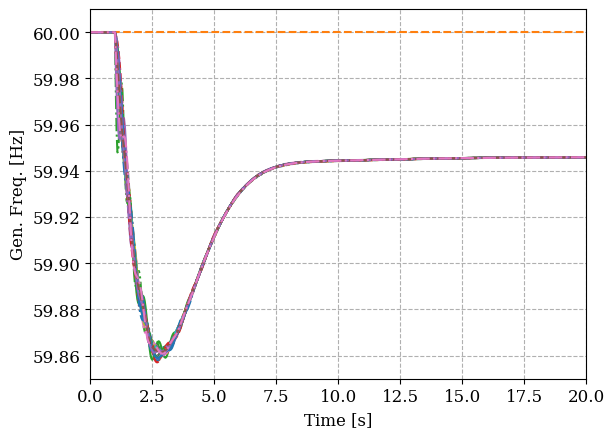

In [11]:
_ = sa.TDS.plt.plot(sa.GENROU.omega,
                    line_width=1.5,
                    ymin=59.85, ymax=60.01,
                    latex=False,
                    show=False,
                    ytimes=sa.config.freq,
                    grid=True,
                    ylabel='Gen. Freq. [Hz]')